# Transfer Learning in Convoultion Neural Network

In this notebook we will demonstrate how transfer learning works in CNN.

We shall use [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset available within [tensorflow datasets](https://www.tensorflow.org/datasets). Please install tensorflow datasets before using this notebook.

## Gather the data

In [1]:
import tensorflow_datasets as tfds

In [2]:
(train_ds, train_labels), (test_ds, test_labels) = tfds.load("tf_flowers", 
                                                             split=["train[:70%]", "train[:30%]"],
                                                             batch_size= -1,
                                                             as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\SouravKarmakar\tensorflow_datasets\tf_flowers\3.0.1.incompleteRI3JUP\tf_flowers-train.tfrec…

Dataset tf_flowers downloaded and prepared to C:\Users\SouravKarmakar\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [4]:
ds, ds_info = tfds.load("tf_flowers", split='train', with_info=True)

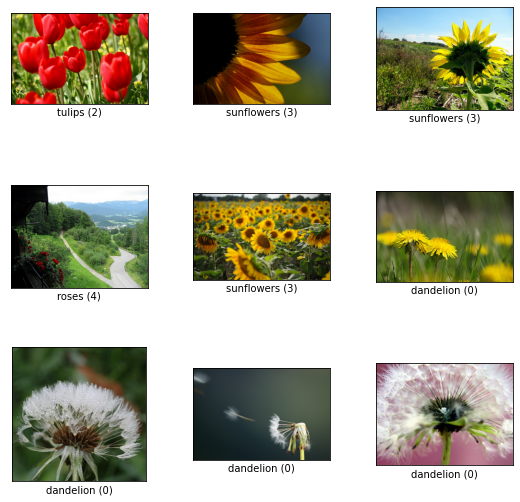

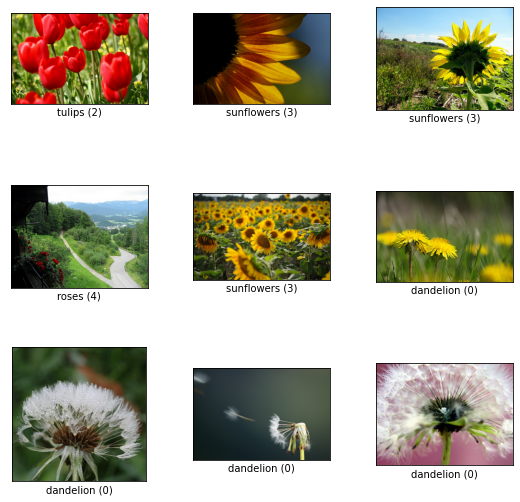

In [5]:
tfds.show_examples(ds, ds_info)

In [6]:
train_ds.shape

TensorShape([2569, 442, 1024, 3])

In [7]:
test_ds.shape

TensorShape([1101, 442, 1024, 3])

In [9]:
train_labels.shape

TensorShape([2569])

## Preprocess the dataset

In [13]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

Converting the image size to (224,224) suitable for VGG16

In [14]:
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224,224))

In [15]:
train_ds.shape, test_ds.shape

(TensorShape([2569, 224, 224, 3]), TensorShape([1101, 224, 224, 3]))

Converting the labels to correct format

In [16]:
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

## Let's look at VGG-16 architecture

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

In [11]:
vgg16_model = VGG16(weights='imagenet', include_top=False)

553467096/553467096 [==============================] - 68s 0us/step


In [12]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Use VGG-16 backbone for transfer learning

- Here we will use the lower portion of VGG-16 for feature extraction. i.e. we will not train this part of VGG16 (freeze the weights).
- Then we will add custom classification layers on top of this
- We will retrain (fine-tune) the entire model on flowers dataset.

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_ds[0].shape)

base_model.trainable = False # Freezing the weights of this part of NN

58889256/58889256 [==============================] - 8s 0us/step


In [18]:
# Preprocess the input

from tensorflow.keras.applications.vgg16 import preprocess_input

In [19]:
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [20]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Create the entire network by adding custom layers

In [21]:
from tensorflow.keras import layers, models

In [22]:
flatten_layer = layers.Flatten()

In [23]:
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

In [24]:
final_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [25]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 50)                1254450   
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 5)                 105       
                                                                 
Total params: 15,970,263
Trainable params: 1,255,575
Non-trainable params: 14,714,688
_________________________________________________________________


## Compile and train the model

In [26]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
final_model.fit(train_ds, train_labels, epochs=20, validation_split=0.2, batch_size=128)

Epoch 1/20
17/17 [==============================] - 571s 34s/step - loss: 2.6022 - accuracy: 0.3805 - val_loss: 1.2187 - val_accuracy: 0.4961
Epoch 2/20
17/17 [==============================] - 511s 30s/step - loss: 0.9584 - accuracy: 0.6058 - val_loss: 1.0917 - val_accuracy: 0.5973
Epoch 3/20
17/17 [==============================] - 469s 28s/step - loss: 0.6341 - accuracy: 0.7547 - val_loss: 1.0615 - val_accuracy: 0.6732
Epoch 4/20
17/17 [==============================] - 484s 29s/step - loss: 0.4330 - accuracy: 0.8394 - val_loss: 1.0419 - val_accuracy: 0.7160
Epoch 5/20
17/17 [==============================] - 461s 27s/step - loss: 0.3145 - accuracy: 0.8827 - val_loss: 1.2442 - val_accuracy: 0.7198
Epoch 6/20
17/17 [==============================] - 485s 29s/step - loss: 0.2215 - accuracy: 0.9178 - val_loss: 1.2251 - val_accuracy: 0.7237
Epoch 7/20
17/17 [==============================] - 484s 29s/step - loss: 0.1416 - accuracy: 0.9523 - val_loss: 1.1426 - val_accuracy: 0.7393
Epoch 

## Evaluating the performance of the model

In [38]:
predictions = final_model.predict(test_ds)

35/35 [==============================] - 237s 7s/step


In [40]:
y_true = test_labels.argmax(axis=1)
y_pred = predictions.argmax(axis=1)

In [41]:
from sklearn.metrics import accuracy_score

In [44]:
print(f"The accuracy of the model is: {100*accuracy_score(y_true=y_true, y_pred=y_pred):.3f}%")

The accuracy of the model is: 99.637%


So we got a very good accuracy by applying transfer learning.

## Saving the model for future use

In [28]:
final_model.save("./flower_classifier_vgg16.h5")